In [51]:
from typing import List, Callable

import numpy as np
import torch as t
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import animation, cm, cbook
from tqdm.notebook import tqdm 

from jax import grad, jit, vmap

# Why Singularities?

I want to built up some intuition for [why singularities in the loss landscape can have such disproportionate effect over the global behavior of training](https://www.lesswrong.com/posts/fovfuFdpuEwQzJu2w/neural-networks-generalize-because-of-this-one-weird-trick).  

## Simple Singularities

As a simple proof of concept, let's study the effect of singularities on the behavior of a simple random walk. To start, let's look at a random walk on two or more intersecting 1D lines. 
We'll let these lines cross at one point (the singularity), and look at the stable distribution of the random walk as we increase the number of lines. To make this tractable, we'll put the lines on a torus.

In [52]:
from collections import Counter


def walk_crossing_lattice(n: int, D=2, L=9) -> np.ndarray:
    """Generate a random walk on D x 1d random walks that intersect at the origin.

    Parameters
    ----------

    n : (int) 
        Number of steps
    D : (int, optional)
        Number of dimensions. Defaults to 2.
    L : (int, optional)
        Length of the lattice. Defaults to 9.

    Returns
    -------
    
    np.ndarray [n, D]
        The walk 
    """
    l = L // 2

    walk = np.zeros((n, D))
    origin = np.zeros(D)

    for i in range(1, n):
        direction = np.random.choice([-1, 1])

        if np.all(walk[i - 1] == origin):
            axis = np.random.randint(D)
            walk[i, axis] = direction
        else:
            axis = np.abs(walk[i - 1]).argmax()
            step = np.zeros(D)
            step[axis] = direction
            walk[i, :] = walk[i - 1] + step

        # Toroidal boundary conditions (-l, l)
        walk[i, :] = np.mod(walk[i, :] + l, L) - l

    return walk

walk_2d = walk_crossing_lattice(100_000, D=2)
walk_3d = walk_crossing_lattice(100_000, D=3)
walk_4d = walk_crossing_lattice(100_000, D=4)
walk_10d = walk_crossing_lattice(100_000, D=10)

In [77]:
def plot_walk_2d(walk: np.ndarray, D=2, ax=None):
    """
    Plot a 2D walk on a 2D lattice. The size of the circles is proportional to the number of visits.
    """
    count = Counter([tuple(x) for x in walk])
    
    # Plot circles at each point with size proportional to the number of visits
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
        
    r = 1. / (max(count.values()) * 5)

    for point, visits in count.items():
        ax.add_artist(plt.Circle(point, radius=visits * r, color='blue', alpha=0.5))

    ax.set_title(f'Random walk on {D}x1D intersecting lattices')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

    ax.axis("off")
    ax.set_aspect('equal')

    print("Ratio of origin visits to other visits:", count[(0, 0)] * len(count.values()) / (sum(count.values()) - count[(0, 0)]))


In [78]:
def project_onto_diagonal(walk: np.ndarray, m=1):
    """Project the z axis onto the y = mx diagonal."""
    walk_2d = np.copy(walk)
    walk_2d[:, 0] += m * walk[:, 2]
    walk_2d[:, 1] += walk[:, 2]
    return walk_2d[:, :2]

def plot_walk_3d(walk: np.ndarray, ax=None):
    """
    Project the z axis onto the x = y diagonal & plot the 2D walk.
    """
    walk_2d = project_onto_diagonal(walk)
    plot_walk_2d(walk_2d, D=3, ax=ax)

Ratio of origin visits to other visits: 2.1114308840723086
Ratio of origin visits to other visits: 3.125597668950465
Ratio of origin visits to other visits: 4.064492216456634
Ratio of origin visits to other visits: 9.848932805437476


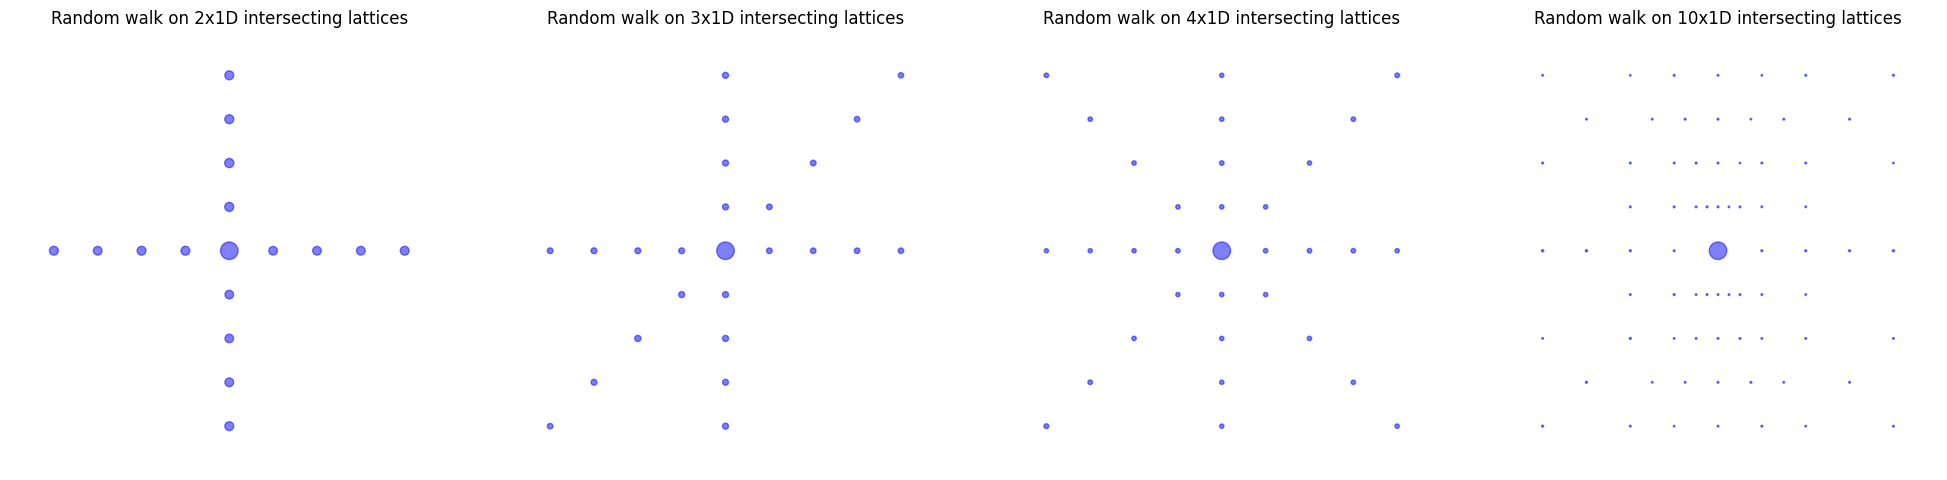

In [79]:
MS = (1, -1, 0.5, -0.5, 2, -2, 0.25, -0.25, 4, -4, 0.75, -0.75)

def project_multiple_onto_diagonal(walk: np.ndarray, ms=MS):
    """Project the >2 axes onto the y = mx diagonal."""
    projected_walk = np.copy(walk)

    if len(ms) <= walk.shape[1] - 2:
        raise ValueError("Number of slopes must be greater than or equal to the number of dimensions - 2")

    for i, m in zip(range(2, walk.shape[1]), ms):
        projected_walk[:, 0] += m * walk[:, i]
        projected_walk[:, 1] += walk[:, i]
        
    return projected_walk[:, :2]


def plot_walk(walk: np.ndarray,  ms=MS, ax=None):
    """
    Project all higher-dim. axis onto x = m * y diagonals & plot the 2D walk.
    """
    D=walk.shape[1]
    walk = project_multiple_onto_diagonal(walk, ms=ms)
    plot_walk_2d(walk, D=D, ax=ax)

fig, axes = plt.subplots(1, 4, figsize=(20, 10))

fig.tight_layout()

plot_walk_2d(walk_2d, ax=axes[0])
plot_walk_3d(walk_3d, ax=axes[1])
plot_walk(walk_4d, ax=axes[2])
plot_walk(walk_10d, ax=axes[3])

This is pretty decisive: the role of the singularity is that it acts as a kind of "trap". The random walk is as many times more likely to be at the singularity as there are lines.

## Fancier singularities

Is this true more broadly? What about cusps and other singularities?
Let's extend this analysis to arbitrary 1D manifolds. We'll generate maps on an arbitrary analytic variety defined by the equation $f(x) = 0$. We'll then look at the stable distribution of the random walk on the manifold as we change the nature of the singularity.

In [66]:
def random_walk_on_curve(
    fun: Callable[[np.ndarray], np.ndarray],
    n_steps: int,
    start: np.ndarray,
    step_size: float = 1e-6,
) -> np.ndarray:
    """Perform a random walk on a curve.

    Parameters
    ----------
    f : Callable[[float, float], np.ndarray]
        The curve to walk on.
    n_steps : int
        The number of steps to take.
    start : np.ndarray
        The starting point of the walk. Must be on the curve.
    step_size : float, optional
        The step size, by default 1.0

    Returns
    -------
    np.ndarray
        The trajectory of the walk.
    """
    walk = [start]

    # grad_fun = grad(fun, argnums=[0, 1])

    for _ in tqdm(range(n_steps), desc="Random walk on curve"):
        dx = 0
        step_size_ = step_size
        curr_pt = walk[-1]

        while dx < step_size:
            # tangent = grad_fun(*curr_pt)
            tangent = np.array(
                [
                    (fun(curr_pt[0] + step_size_, curr_pt[1]) - fun(curr_pt[0], curr_pt[1])) / step_size_,
                    (fun(curr_pt[0], curr_pt[1] + step_size_) - fun(curr_pt[0], curr_pt[1])) / step_size_,
                ]
            )
            tangent /= np.linalg.norm(tangent)

            next_pt = curr_pt + step_size_ * tangent

            # Check if the next point is on the curve
            if np.allclose(fun(*next_pt), 0):
                dx += step_size_
                curr_pt = next_pt
            else:
                # Shrink step_size_ until next_pt is on the curve
                step_size_ /= 2
        
        walk.append(curr_pt)

    return np.array(walk)

/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_40307/2490885684.py:13: RuntimeWarning: invalid value encountered in sqrt
  ymins = np.sqrt(x ** 2 * (x + 1))


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot: title={'center': 'Double Point singularity'}, xlabel='x', ylabel='y'>)

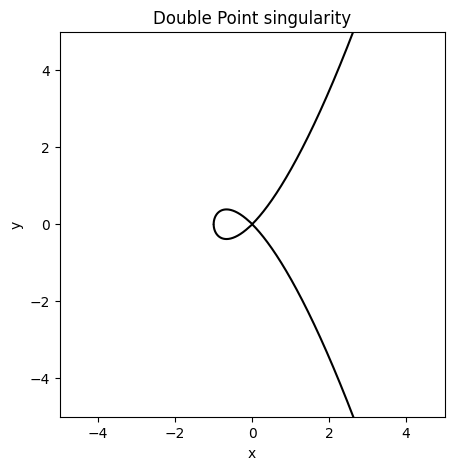

In [67]:
def plot_double_pt_singularity(xlim=(-5, 5), ylim=(-5, 5)):
    # y2 − x2(x + 1) = 0

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect("equal")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Double Point singularity")

    x = np.linspace(*xlim, 10000)
    ymins = np.sqrt(x ** 2 * (x + 1))
    ymaxs = -ymins

    ax.plot(x, ymins, color="black")
    ax.plot(x, ymaxs, color="black")

    return fig, ax

plot_double_pt_singularity()

In [68]:
def plot_random_walk_on_curve(
    fun: Callable[[np.ndarray], np.ndarray],
    n_steps: int,
    start: np.ndarray,
    step_size: float = 1.0,
    xlim=(-5, 5),
    ylim=(-5, 5),
):
    trajectory = random_walk_on_curve(fun, n_steps, start, step_size)

    fig, ax = plot_double_pt_singularity(xlim, ylim)

    ax.plot(trajectory[:, 0], trajectory[:, 1], color="blue")

    return fig, ax

plot_random_walk_on_curve(
    lambda x, y: y - np.sqrt(x ** 2 * (x + 1)),
    100,
    np.array([0., 0.]),
    step_size=0.1,
)

Random walk on curve:   0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_40307/416782329.py:42: RuntimeWarning: invalid value encountered in divide
  tangent /= np.linalg.norm(tangent)
/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_40307/416782329.py:38: RuntimeWarning: invalid value encountered in scalar divide
  (fun(curr_pt[0] + step_size_, curr_pt[1]) - fun(curr_pt[0], curr_pt[1])) / step_size_,
/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_40307/416782329.py:39: RuntimeWarning: invalid value encountered in scalar divide
  (fun(curr_pt[0], curr_pt[1] + step_size_) - fun(curr_pt[0], curr_pt[1])) / step_size_,


KeyboardInterrupt: 